# K Nearest Neighbors (KNN)

In [5]:
from my_functions import *

In [6]:
class NN():
  def __init__(self, index:int, distance:float, label:str):
      self.index = index
      self.distance = distance
      self.label = label
  def __repr__(self) -> str:
      return '('+str(self.index)+', '+str(self.distance)+', '+self.label+')'

In [7]:
class KNN:
  def __init__(self, K=1):
    self.K=K

  def fit(self, X:pd.DataFrame, y:list):
    # Train
    self.X = X
    self.y = y

  def predict(self, X=pd.DataFrame):
    predictions = []
    for te in X.values:
      # starting empthy KNNs with infinet distance
      KNNs = [NN(-1, math.inf, 'unkown') for i in range(self.K)]
      for ta_i, ta in enumerate(self.X.values):
        # finding the distance between te and ta
        distance = euclidean_distance(ta, te)
        crr_neighbor = NN(ta_i, distance, self.y[ta_i])
        # check if the crr_neigbor is a KNNs
        for knn_i, knn in enumerate(KNNs):
          # if the crr_neighor is that the knn
          if crr_neighbor.distance < knn.distance:
            # insert crr_neighbor in the knn_i
            KNNs.insert(knn_i, crr_neighbor)
            # and drop the further knn
            KNNs.pop()
            break
      # after get the KNNs get the label moda
      KNNs_labels = list(map(lambda e: e.label, KNNs))
      prediction = compute_moda(KNNs_labels)
      #store prediction
      predictions.append(prediction)
    # return predctions
    return predictions

  @staticmethod
  def Ks_Accs_Stds(dataset, label_column, max_k, step=1):
    Ks, accuracies, standard_deviations = [], [], []
    number_of_interactions = 20
    unique_labels = list(dataset[label_column].unique())
    for k in tqdm(range(1, max_k + 1, step)):
      # compute 20 interactions
      cms = []
      for _ in range(20):
          model = KNN(K=k)
          pred, actu = interaction(dataset, model, label=label_column)
          cm = confusion_matrix(unique_labels, actu, pred)
          cms.append(np.array(cm))
      # compute hit rates
      hit_rates = compute_hit_rates(cms)
      # compute accuracy and standar_deviation
      accuracy = compute_mean(hit_rates)
      standard_deviation = compute_standard_deviation(hit_rates)
      # store results
      Ks.append(k)
      accuracies.append(accuracy)
      standard_deviations.append(standard_deviation)
    return Ks, accuracies, standard_deviations

  @staticmethod
  def compute_Acc_Std(dataset, label_column, u_labels, k, n_int=20):
    cms = []
    for _ in range(n_int):
        model = KNN(K=k)
        pred, actu = interaction(dataset, model, label=label_column)
        cm = confusion_matrix(u_labels, actu, pred)
        cms.append(np.array(cm))
    # compute hit rates
    hit_rates = compute_hit_rates(cms)
    # compute accuracy and standar_deviation
    acc = compute_mean(hit_rates)
    std = compute_standard_deviation(hit_rates)
    return acc, std

  @staticmethod 
  def lg_Ks_Accs_Stds(dataset, label_column, max_k):
    Ks, Accs, Stds = [], [], []
    n_interactions = 20
    u_labels = list(dataset[label_column].unique())
    start = 1
    end = max_k
    acc, std = KNN.compute_Acc_Std(dataset, label_column, u_labels, start)
    Ks.append(start)
    Accs.append(acc)
    Stds.append(std)
    score_start = acc - std
    acc, std = KNN.compute_Acc_Std(dataset, label_column, u_labels, end)
    Ks.append(end)
    Accs.append(acc)
    Stds.append(std)
    score_end = acc - std
    mid = int(((end - start) / 2) + start)
    for _ in tqdm(range(int(math.log2(max_k))+1)):
      if start == mid:
        acc, std = KNN.compute_Acc_Std(dataset, label_column, u_labels, start)
        Ks.append(start)
        Accs.append(acc)
        Stds.append(std)
        score_start = acc - std
      elif end == mid:
        acc, std = KNN.compute_Acc_Std(dataset, label_column, u_labels, end)
        Ks.append(end)
        Accs.append(acc)
        Stds.append(std)
        score_end = acc - std

      mid = int(((end - start) / 2) + start)
      if score_start > score_end:
        end = mid
      else:
        start = mid

    return Ks, Accs, Stds

  @staticmethod
  def get_the_best_k(Ks:list, Accs:list, Stds:list):
    best_k = Ks[0]
    best_k_score = Accs[0] - Stds[0]
    for i in range(1, len(Ks)):
        crr_k_score = Accs[i] - Stds[i]
        if crr_k_score > best_k_score:
            best_k_score = crr_k_score
            best_k = Ks[i]
    return best_k

# Iris Dataset

In [8]:
# Download Iris data
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

In [9]:
# Load Iris dataset as a pandas DataFrame
iris_column_names = ['Sepal_Length', 'Sepal_Width','Petal_Length', 'Petal_Width', 'Class']
iris = pd.read_csv('./datasets//iris.data', names=iris_column_names, sep=',')
iris.head(2)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [10]:
# Normalize Iris dataset
features = iris.columns[:-1]
iris = normalize_data(iris, features)
iris.head(2)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
0,0.222222,0.625000,0.067797,0.041667,Iris-setosa
1,0.166667,0.416667,0.067797,0.041667,Iris-setosa


In [11]:
# Does interactions over the dataset, colecting accuracy and standard_deviation
dataset = iris
label_column = 'Class'
train_size = int(.8 * len(dataset))
max_k = train_size
file_name = './KNN_cache/lg_iris_Ks_Accs_Stds.csv'
try:
  # if alread done
  Ks_Accs_Stds = pd.read_csv(file_name)
  Ks = Ks_Accs_Stds['Ks']
  Accs = Ks_Accs_Stds['Accs']
  Stds = Ks_Accs_Stds['Stds']
except:
  # else not, compute now
  Ks, Accs, Stds = KNN.lg_Ks_Accs_Stds(
    dataset,
    label_column,
    max_k
  )
  # then save the result
  os.system('mkdir KNN_cache')
  pd.DataFrame({
    'Ks': Ks,
    'Accs': Accs,
    'Stds': Stds,
  }).to_csv(file_name)

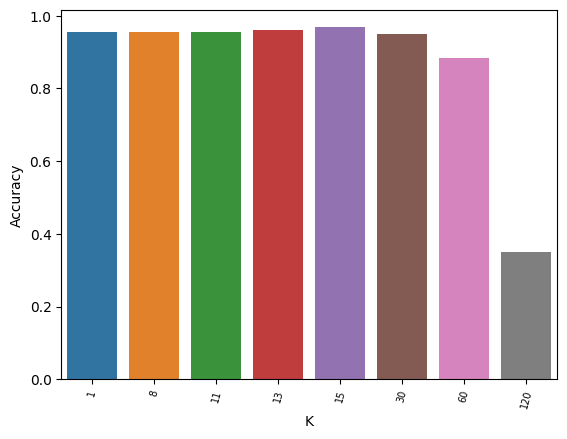

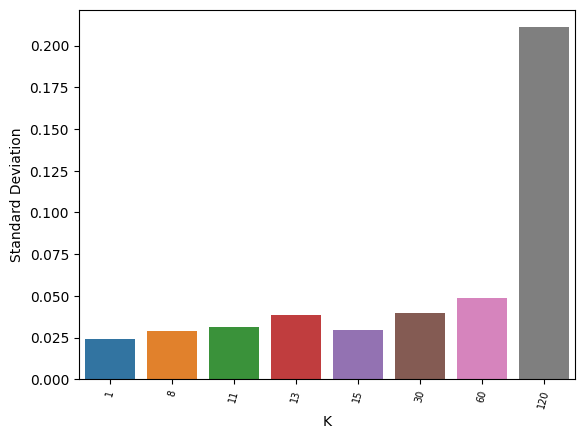

In [12]:
# Accuracy variation over K values
plot_bar_graficy({
    'K': Ks,
    'Accuracy': Accs,
})
plot_bar_graficy({
    'K': Ks,
    'Standard Deviation': Stds,
})

In [13]:
best_k = KNN.get_the_best_k(Ks, Accs, Stds)
print('Best K: ', best_k)

Best K:  15


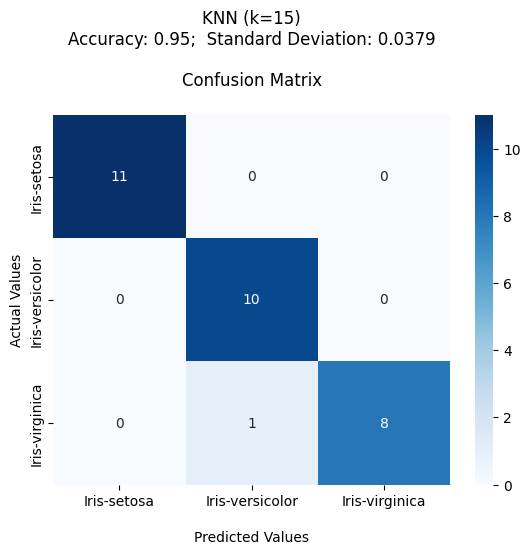

In [14]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(iris, 'Class', KNN, [best_k], 'KNN (k={})'.format(best_k))

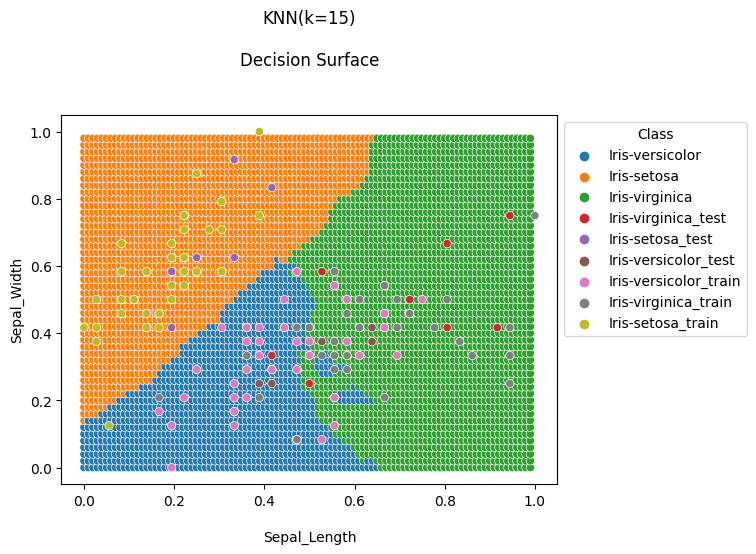

In [15]:
# Compute decision boundary or Decision Surface or "Superfície de decisão"
selected_feats = compute_selected_feats(dataset, label_column)
ds = decision_surface(KNN(K=best_k), dataset, selected_feats, label_column)
plot_scatter(ds, selected_feats, label_column, 'KNN(k={})\n\nDecision Surface'.format(best_k))

# Coluna Dataset

In [16]:

# Download Coluna dataset
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip')
# unzip the vertebral_column_data file
os.system('sudo apt install unzip & unzip ./datasets/vertebral_column_data.zip')

1

In [17]:
# Load Coluna dataset as a pandas DataFrame
coluna_features = [
'pelvic_incidence',
'pelvic_tilt',
'lumbar_lordosis_angle',
'sacral_slope',
'pelvic_radius',
'degree_spondylolisthesis',
'label'
]
coluna = pd.read_csv('./datasets/column_3C.dat',  sep=' ', names=coluna_features, header=None)
coluna.head(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,label
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH


In [18]:
# Normalize Coluna dataset (0 - 1)
features = coluna.columns[:-1]
normalize_data(coluna, features)
coluna.head(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,label
0,0.355710,0.519829,0.229193,0.250879,0.307452,0.025163,DH
1,0.124518,0.296713,0.098622,0.144642,0.476718,0.036359,DH


In [19]:
# Does interactions over the dataset, colecting accuracy and standard_deviation
dataset = coluna
label_column = 'label'
train_size = int(.8 * len(dataset))
max_k = train_size
file_name = './KNN_cache/lg_coluna_Ks_Accs_Stds.csv'
try:
  # if alread done
  Ks_Accs_Stds = pd.read_csv(file_name)
  Ks = Ks_Accs_Stds['Ks']
  Accs = Ks_Accs_Stds['Accs']
  Stds = Ks_Accs_Stds['Stds']
except:
  # else not, compute now
  Ks, Accs, Stds = KNN.lg_Ks_Accs_Stds(
    dataset,
    label_column,
    max_k
  )
  # then save the result
  pd.DataFrame({
    'Ks': Ks,
    'Accs': Accs,
    'Stds': Stds,
  }).to_csv(file_name)

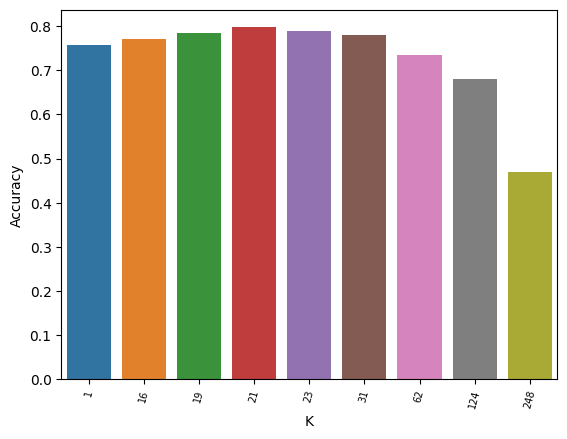

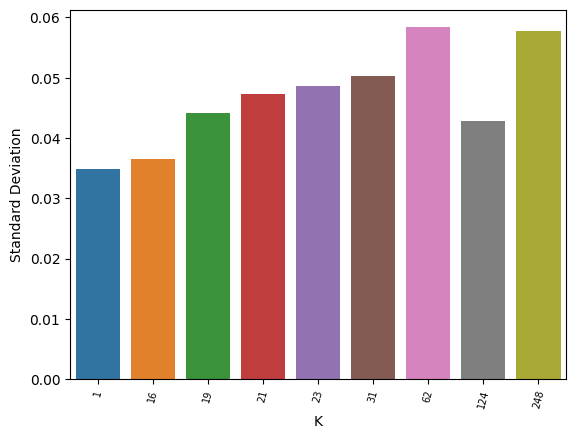

In [20]:
# Accuracy variation over K values
plot_bar_graficy({
    'K': Ks,
    'Accuracy': Accs,
})
# Standard Deviation variation over K values
plot_bar_graficy({
    'K': Ks,
    'Standard Deviation': Stds,
})

In [21]:
best_k = KNN.get_the_best_k(Ks, Accs, Stds)
print('Best K: ', best_k)

Best K:  21


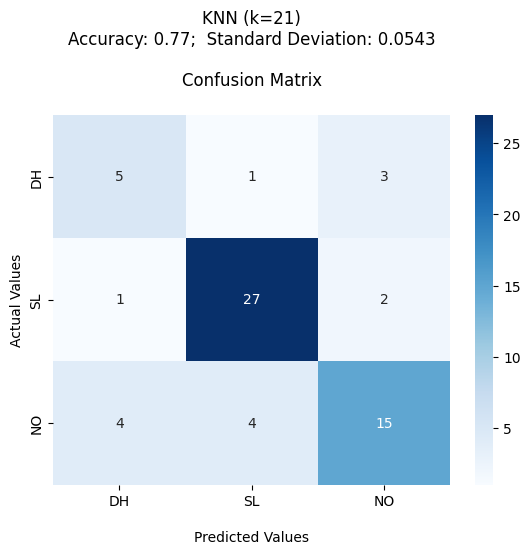

In [22]:
# Compute a confusion matrix or "matriz de confusão"
label_column = 'label'
plot_acc_std_closest_cm_to_the_mean(coluna, label_column, KNN, [best_k], 'KNN (k={})'.format(best_k))

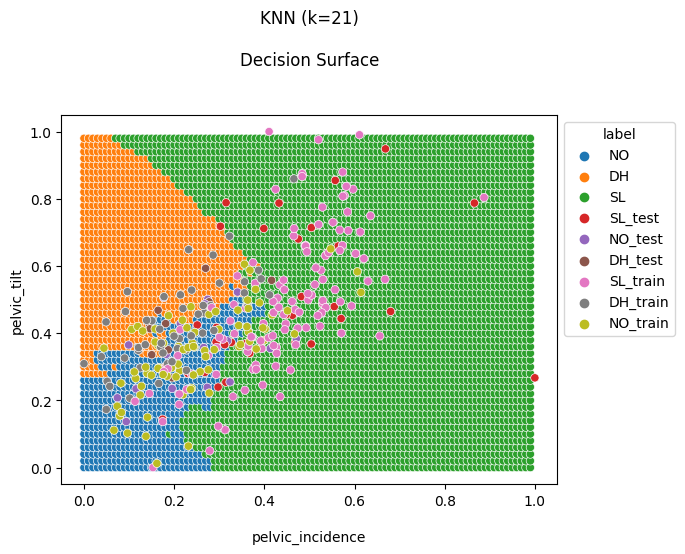

In [23]:
selected_feats = compute_selected_feats(coluna, label_column)
# Compute decision boundary or Decision Surface or "Superfície de decisão"
ds = decision_surface(KNN(K=best_k), dataset, selected_feats, label_column)
plot_scatter(ds, selected_feats, label_column, 'KNN (k={})\n\nDecision Surface'.format(best_k))

# Breast Cancer Wisconsin (Diagnostic) DataSet

In [24]:
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data')

In [25]:
wdbc_column_names = [
    "id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst",
]
breast_cancer_wisconsin = pd.read_csv('./datasets/wdbc.data', names=wdbc_column_names, sep=',')
breast_cancer_wisconsin = breast_cancer_wisconsin.drop(columns=['id'])
breast_cancer_wisconsin.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [26]:
label_column = 'diagnosis'
# Normalize dataset
features = breast_cancer_wisconsin.drop(columns=[label_column]).columns
breast_cancer_wisconsin = normalize_data(breast_cancer_wisconsin, features)
breast_cancer_wisconsin.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,M,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878


In [27]:
# Does interactions over the dataset, colecting accuracy and standard_deviation
dataset = breast_cancer_wisconsin
label_column = 'diagnosis'
train_size = int(.8 * len(dataset))
max_k = train_size
file_name = './KNN_cache/lg_breast_cancer_Ks_Accs_Stds.csv'
try:
  # if alread done
  Ks_Accs_Stds = pd.read_csv(file_name)
  Ks = Ks_Accs_Stds['Ks']
  Accs = Ks_Accs_Stds['Accs']
  Stds = Ks_Accs_Stds['Stds']
except:
  # else not, compute now
  Ks, Accs, Stds = KNN.lg_Ks_Accs_Stds(
    dataset,
    label_column,
    max_k
  )
  # then save the result
  pd.DataFrame({
    'Ks': Ks,
    'Accs': Accs,
    'Stds': Stds,
  }).to_csv(file_name)

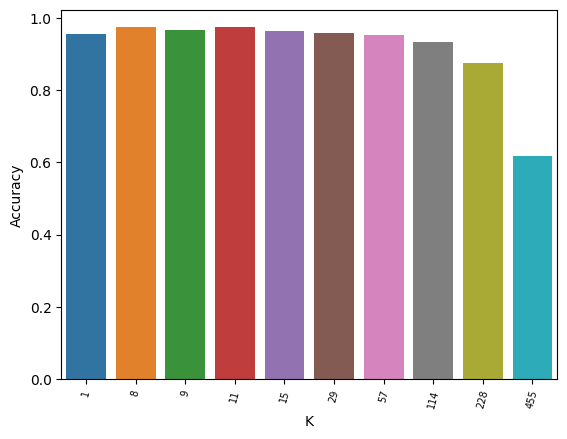

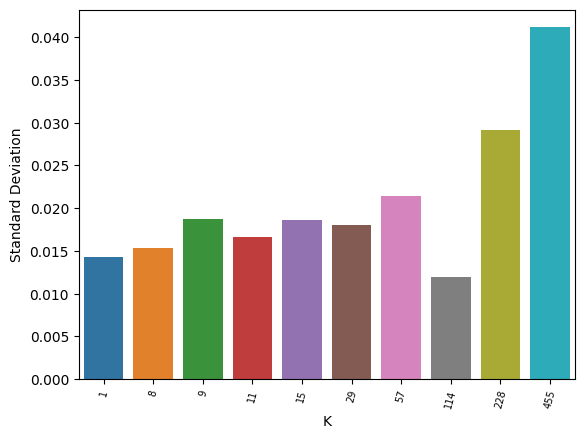

In [28]:
# Accuracy variation over K values
plot_bar_graficy({
    'K': Ks,
    'Accuracy': Accs,
})
# Standard Deviation variation over K values
plot_bar_graficy({
    'K': Ks,
    'Standard Deviation': Stds,
})

In [29]:
best_k = KNN.get_the_best_k(Ks, Accs, Stds)
print('Best K: ', best_k)

Best K:  8


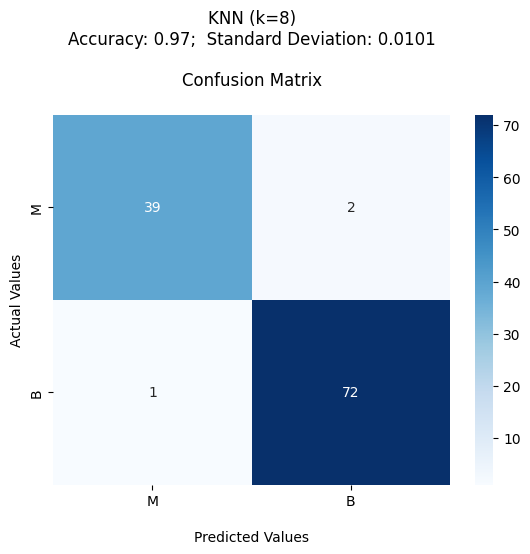

In [30]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dataset, label_column, KNN, [best_k], 'KNN (k={})'.format(best_k))

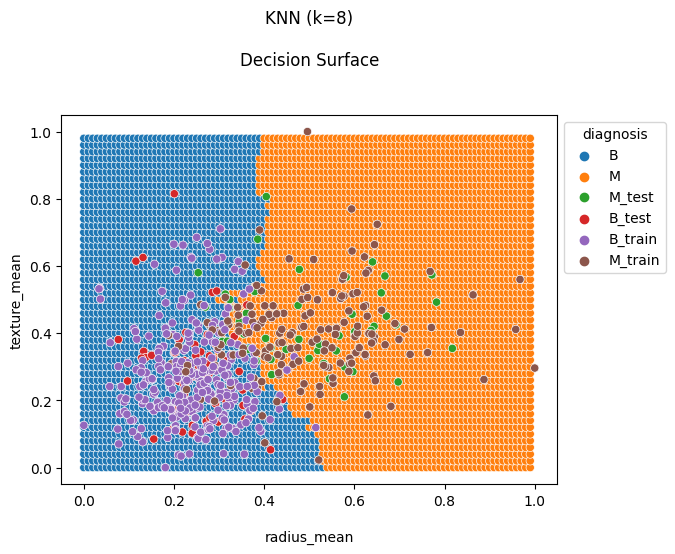

In [31]:
selected_feats = compute_selected_feats(dataset, label_column)
df = decision_surface(KNN(K=best_k), dataset, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'KNN (k={})\n\nDecision Surface'.format(best_k))

# Dermatology Dataset

In [32]:
download_file('https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data')

In [33]:
dermatology_column_names = [
      'erythema',
      'scaling',
      'definite borders',
      'itching',
      'koebner phenomenon',
      'polygonal papules',
      'follicular papules',
      'oral mucosal involvement',
      'knee and elbow involvement',
      'scalp involvement',
      'family history',
      'melanin incontinence',
      'eosinophils in the infiltrate',
      'PNL infiltrate',
      'fibrosis of the papillary dermis',
      'exocytosis',
      'acanthosis',
      'hyperkeratosis',
      'parakeratosis',
      'clubbing of the rete ridges',
      'elongation of the rete ridges',
      'thinning of the suprapapillary epidermis',
      'spongiform pustule',
      'munro microabcess',
      'focal hypergranulosis',
      'disappearance of the granular layer',
      'vacuolisation and damage of basal layer',
      'spongiosis',
      'saw-tooth appearance of retes',
      'follicular horn plug',
      'perifollicular parakeratosis',
      'inflammatory monoluclear inflitrate',
      'band-like infiltrate',
      'Age',
      'Class',
]
dermatology = pd.read_csv('./datasets/dermatology.data', names=dermatology_column_names, sep=',')

In [34]:
label_column = 'Class'
missing_value = '?'
# Replacing missing values by the mean
unique_values = list(dermatology['Age'].unique())
unique_values.remove(missing_value)
mean_without_misses  = compute_mean(dermatology['Age'].filter(items=unique_values))
dermatology['Age'] = dermatology['Age'].apply(lambda v: mean_without_misses if v == missing_value else float(v))

In [35]:
# Normalize dataset
features = dermatology.drop(columns=[label_column]).columns
dermatology = normalize_data(dermatology, features)
dermatology.head(2)

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Class
0,0.666667,0.666667,0.0,1.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.733333,2
1,1.000000,1.000000,1.0,0.666667,0.333333,0.0,0.0,0.0,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.106667,1


In [36]:
# Does interactions over the dataset, colecting accuracy and standard_deviation
dataset = dermatology
label_column = 'Class'
train_size = int(.8 * len(dataset))
max_k = train_size
file_name = './KNN_cache/lg_dermatology_Ks_Accs_Stds.csv'
try:
  # if alread done
  Ks_Accs_Stds = pd.read_csv(file_name)
  Ks = Ks_Accs_Stds['Ks']
  Accs = Ks_Accs_Stds['Accs']
  Stds = Ks_Accs_Stds['Stds']
except:
  # else not, compute now
  Ks, Accs, Stds = KNN.lg_Ks_Accs_Stds(
    dataset,
    label_column,
    max_k
  )
  # then save the result
  pd.DataFrame({
    'Ks': Ks,
    'Accs': Accs,
    'Stds': Stds,
  }).to_csv(file_name)

In [37]:
best_k = KNN.get_the_best_k(Ks, Accs, Stds)
print('Best K: ', best_k)

Best K:  3


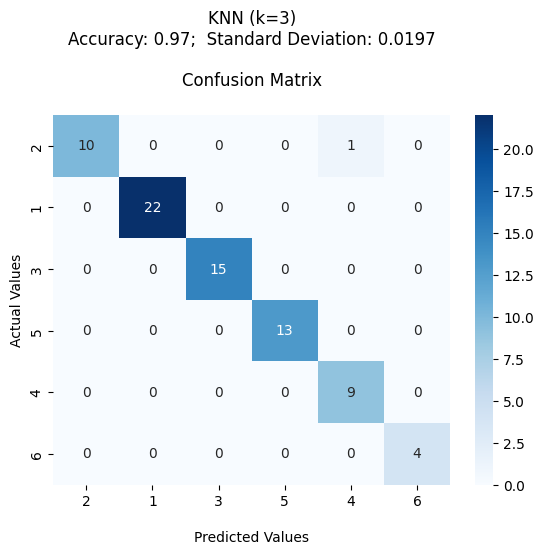

In [38]:
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dataset, label_column, KNN, [best_k], 'KNN (k={})'.format(best_k))

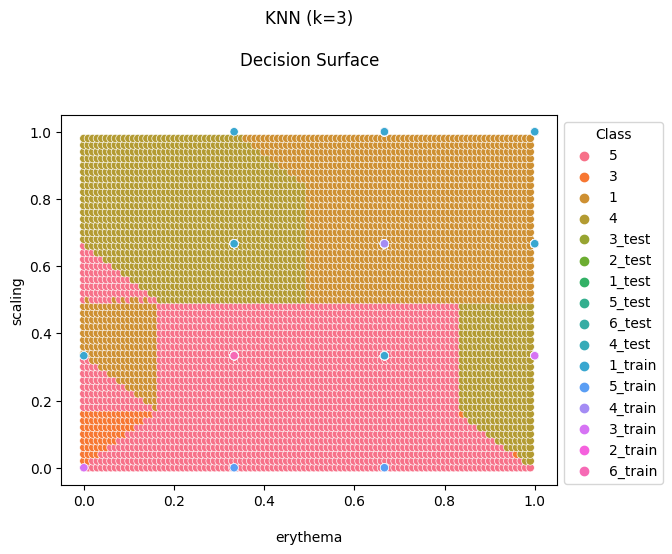

In [39]:
selected_feats = compute_selected_feats(dataset, label_column)
df = decision_surface(KNN(K=best_k), dataset, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'KNN (k={})\n\nDecision Surface'.format(best_k))

# Artifical Dataset

In [40]:
# Generate dataset, Artificial II
dataset_size = 150
noise = 0.1
centroid_size = int(dataset_size / 3)
classe1_size = centroid_size
classe2_size = centroid_size
classe3_size = centroid_size
c1_centroids = [
    [0.25, 0.75],
]
c2_centroids = [
    [0.75, 0.75],
]
c3_centroids = [
    [0.50, 0.25],
]
x1, x2, label = [], [], []
for centroid in c1_centroids:
    for _ in range(classe1_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_1')
for centroid in c2_centroids:
    for _ in range(classe2_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_2')
for centroid in c3_centroids:
    for _ in range(classe3_size):
        noise1 = random.random() * noise - noise / 2
        noise2 = random.random() * noise - noise / 2
        x1.append(centroid[0] + noise1)
        x2.append(centroid[1] + noise2)
        label.append('classe_3')


In [41]:
artificial_dataset = pd.DataFrame({
    'feature_1': x1,
    'feature_2': x2,
    'label': label
})

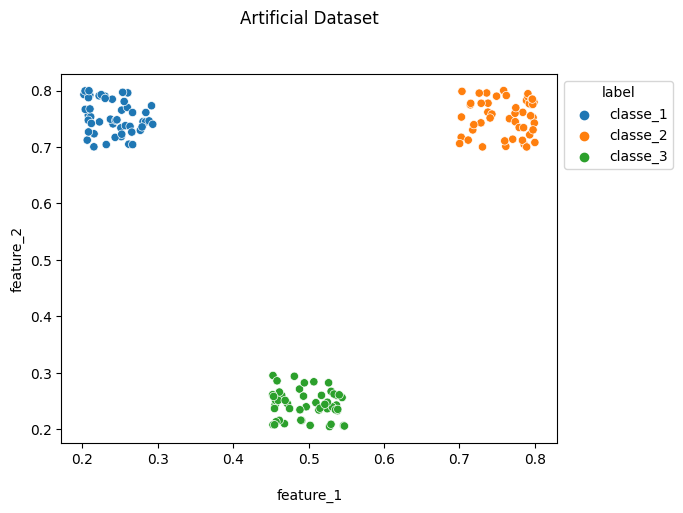

In [42]:
features = ['feature_1', 'feature_2']
plot_scatter(artificial_dataset, features, label='label', title='Artificial Dataset')

In [43]:
# Does interactions over the dataset, colecting accuracy and standard_deviation
dataset = artificial_dataset
label_column = 'label'
train_size = int(.8 * len(dataset))
max_k = train_size
file_name = './KNN_cache/lg_artificial_Ks_Accs_Stds.csv'
try:
  # if alread done
  Ks_Accs_Stds = pd.read_csv(file_name)
  Ks = Ks_Accs_Stds['Ks']
  Accs = Ks_Accs_Stds['Accs']
  Stds = Ks_Accs_Stds['Stds']
except:
  # else not, compute now
  Ks, Accs, Stds = KNN.lg_Ks_Accs_Stds(
    dataset,
    label_column,
    max_k
  )
  # then save the result
  pd.DataFrame({
    'Ks': Ks,
    'Accs': Accs,
    'Stds': Stds,
  }).to_csv(file_name)


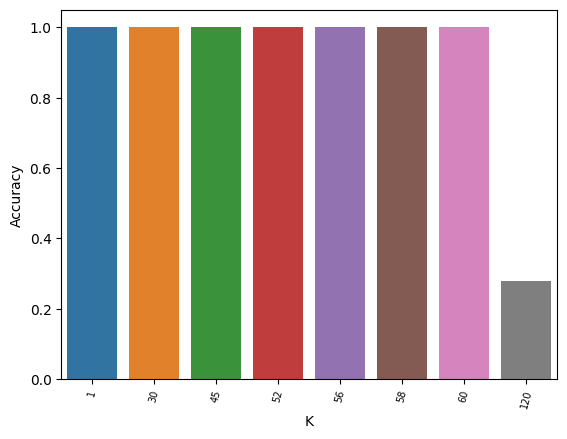

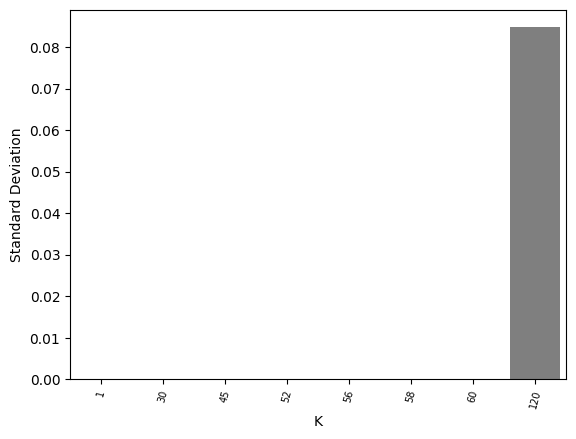

In [44]:
# Accuracy variation over K values
plot_bar_graficy({
    'K': Ks,
    'Accuracy': Accs,
})
# Standard Deviation variation over K values
plot_bar_graficy({
    'K': Ks,
    'Standard Deviation': Stds,
})

In [45]:
best_k = KNN.get_the_best_k(Ks, Accs, Stds)
print('Best k:', best_k)

Best k: 1


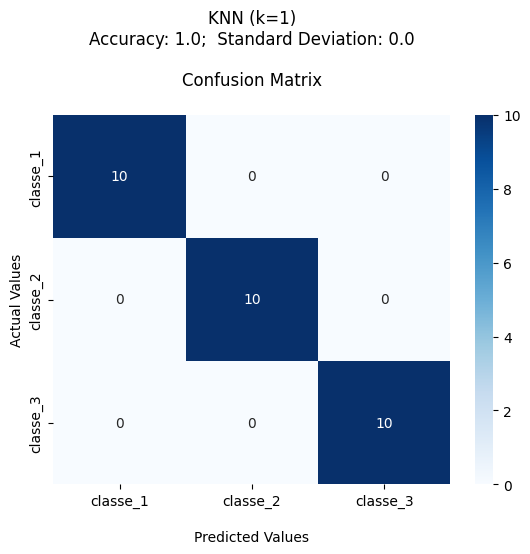

In [46]:
# Compute a confusion matrix or "matriz de confusão"
dataset = artificial_dataset
label_column = 'label'
# Compute a confusion matrix or "matriz de confusão"
plot_acc_std_closest_cm_to_the_mean(dataset, label_column, KNN, [best_k], 'KNN (k={})'.format(best_k))

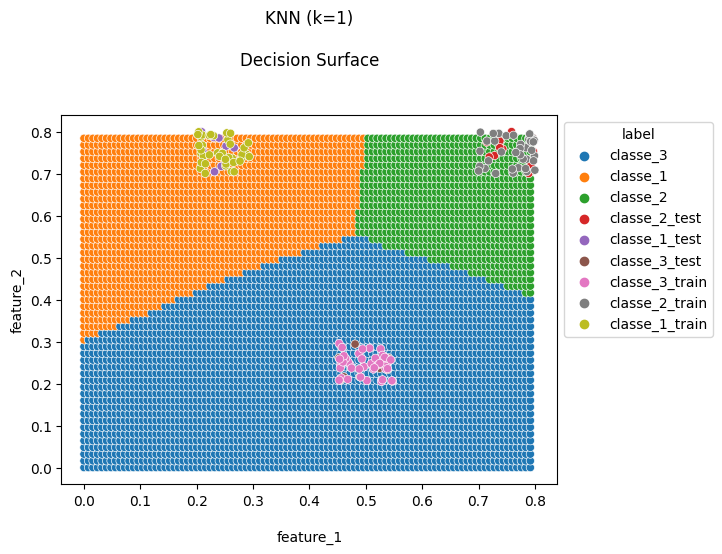

In [47]:
selected_feats = artificial_dataset.columns[:-1]
df = decision_surface(KNN(K=best_k), dataset, selected_feats, label_column)
plot_scatter(df, selected_feats, label_column, 'KNN (k={})\n\nDecision Surface'.format(best_k))